In [1]:
import keras
from keras import regularizers, optimizers
from keras import losses
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM
from keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence

from keras.layers import Conv1D, Flatten, Activation, SpatialDropout1D
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils import to_categorical

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
 
from sklearn.metrics import confusion_matrix, roc_auc_score,precision_recall_curve
from sklearn.metrics import classification_report,auc

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow 
import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tensorflow.__version__)


Using TensorFlow backend.


Python:  3.7.0 (default, Jun 28 2018, 08:04:48) [MSC v.1912 64 bit (AMD64)]
pandas:  0.23.4
numpy:  1.19.1
seaborn:  0.9.0
matplotlib:  2.2.3
sklearn:  0.19.2
Keras:  2.3.1
Tensorflow:  2.1.0


In [2]:
df = pd.read_csv("../data/phase2_train.csv", sep=",", index_col=None)
print(df.shape)
pd.options.display.max_columns = None
df.head(5)
print(df['label'].value_counts())

(3004066, 4)
0    2924512
1      79554
Name: label, dtype: int64


In [4]:
print(df[190000:300000])

         timestamp      value  label                                KPI ID
190000  1494672480   0.000000      0  7103fa0f-cac4-314f-addc-866190247439
190001  1494672540   0.000000      0  7103fa0f-cac4-314f-addc-866190247439
190002  1494672600   0.000000      0  7103fa0f-cac4-314f-addc-866190247439
190003  1494672660   0.000000      0  7103fa0f-cac4-314f-addc-866190247439
190004  1494672720   0.000000      0  7103fa0f-cac4-314f-addc-866190247439
190005  1494672780   0.000000      0  7103fa0f-cac4-314f-addc-866190247439
190006  1494672840   0.000000      0  7103fa0f-cac4-314f-addc-866190247439
190007  1494672900   0.000000      0  7103fa0f-cac4-314f-addc-866190247439
190008  1494672960   0.000000      0  7103fa0f-cac4-314f-addc-866190247439
190009  1494673020   0.000000      0  7103fa0f-cac4-314f-addc-866190247439
190010  1494673080   0.000000      0  7103fa0f-cac4-314f-addc-866190247439
190011  1494673140   0.000000      0  7103fa0f-cac4-314f-addc-866190247439
190012  1494673200   0.00

In [5]:
data= df[["value","label"]]
a=data[440000:500000]##点集2400000:2500000,1100000:1200000
print(a['label'].value_counts())
normal=a[a['label']== 0]#55000:100000
normal=normal["value"]
test=data[508000:512000]
print(test['label'].value_counts())
test_label=test['label']
test=np.array(test['value'])
train=np.array(normal)
timesquence=20
trim=len(train)%timesquence
train=train[:len(train)-trim]
train.shape=(int(len(train)/timesquence),timesquence,1)
print("train",train.shape)
trim=len(test)%timesquence
test=test[:len(test)-trim]
test.shape=(int(len(test)/timesquence),timesquence,1)
print("test",test.shape)

0    59838
1      162
Name: label, dtype: int64
0    3520
1     480
Name: label, dtype: int64
train (2991, 20, 1)
test (200, 20, 1)


In [6]:
# convolutional layer parameters
from keras.layers import  Lambda
n_filters = 32 
filter_width = 2
dilation_rates = [2**i for i in range(4)] 
# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, 1))
x = history_seq
for dilation_rate in dilation_rates:
    x = Conv1D(filters=n_filters,
               kernel_size=filter_width, 
              kernel_regularizer=regularizers.l2(0.02),
               padding='causal',
               dilation_rate=dilation_rate,activation='relu')(x)

x = Dense(128, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(1)(x)
# extract the last 14 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]
pred_seq_train = Lambda(slice, arguments={'seq_length':timesquence})(x)

TCN = Model(history_seq, pred_seq_train)
TCN.compile(optimizer=optimizers.Adam(), loss='mean_absolute_error')
TCN.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          96        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
dense_1 (Dense)              (None, None, 128)         4224      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 128)         0   

In [7]:
from keras.callbacks import TensorBoard
tensorboard=tensorflow.keras.callbacks.TensorBoard(histogram_freq=1)
history=TCN.fit(train, train,
          batch_size=2**10,
          epochs=50,
          validation_data=(test, test))
         # callbacks = [tensorboard])


Train on 2991 samples, validate on 200 samples
Epoch 1/50
2991/2991 [==============================] - 5s 2ms/step - loss: 3.5191 - val_loss: 3.1241
Epoch 2/50
2991/2991 [==============================] - 1s 350us/step - loss: 3.3559 - val_loss: 2.9529
Epoch 3/50
2991/2991 [==============================] - 1s 317us/step - loss: 3.1518 - val_loss: 2.7408
Epoch 4/50
2991/2991 [==============================] - 1s 312us/step - loss: 2.8900 - val_loss: 2.4743
Epoch 5/50
2991/2991 [==============================] - 1s 338us/step - loss: 2.5498 - val_loss: 2.1520
Epoch 6/50
2991/2991 [==============================] - 1s 330us/step - loss: 2.2265 - val_loss: 2.0842
Epoch 7/50
2991/2991 [==============================] - 1s 336us/step - loss: 2.1748 - val_loss: 2.0838
Epoch 8/50
2991/2991 [==============================] - 1s 325us/step - loss: 2.1313 - val_loss: 1.9729
Epoch 9/50
2991/2991 [==============================] - 1s 319us/step - loss: 1.9808 - val_loss: 1.8077
Epoch 10/50
2991/29

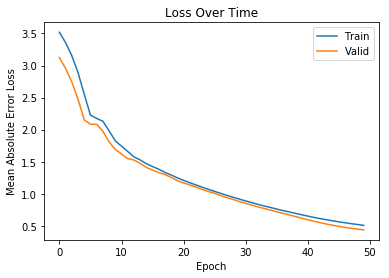

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [9]:
test_pred = TCN.predict(test)
print(test_pred.shape)
print(test[0:20])
print("-------------------------")
print(test_pred[0:10])


(200, 20, 1)
[[[1.75      ]
  [1.85000002]
  [1.85000002]
  [1.85000002]
  [1.79999995]
  [2.0999999 ]
  [1.79999995]
  [1.60000002]
  [1.79999995]
  [1.89999998]
  [1.70000005]
  [1.89999998]
  [1.60000002]
  [1.85000002]
  [1.89999998]
  [1.75      ]
  [2.04999995]
  [1.85000002]
  [1.64999998]
  [1.89999998]]

 [[1.95000005]
  [1.85000002]
  [1.70000005]
  [1.89999998]
  [1.85000002]
  [1.85000002]
  [2.0999999 ]
  [1.79999995]
  [1.85000002]
  [1.85000002]
  [1.85000002]
  [1.79999995]
  [1.85000002]
  [1.85000002]
  [1.75      ]
  [1.79999995]
  [1.85000002]
  [1.75      ]
  [1.89999998]
  [2.        ]]

 [[1.70000005]
  [1.79999995]
  [1.89999998]
  [1.64999998]
  [2.75      ]
  [1.79999995]
  [1.75      ]
  [1.89999998]
  [1.79999995]
  [1.85000002]
  [1.75      ]
  [1.79999995]
  [1.95000005]
  [1.89999998]
  [1.70000005]
  [1.79999995]
  [1.64999998]
  [1.70000005]
  [1.95000005]
  [1.75      ]]

 [[1.64999998]
  [2.        ]
  [1.85000002]
  [1.75      ]
  [2.0999999 ]
  [1.7

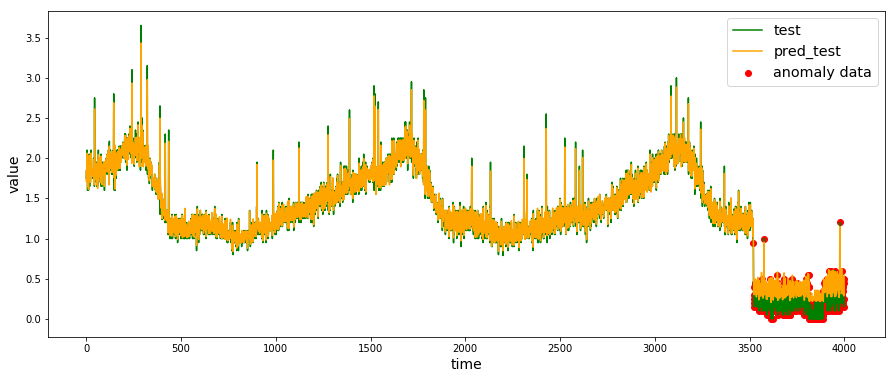

In [10]:
test1=test.reshape(test.shape[0]*test.shape[1],1)
test_pred1=test_pred.reshape(test_pred.shape[0]*test_pred.shape[1],1)
plt.figure(figsize=(15,6))
plt.xlabel('time',fontsize=14)
plt.ylabel('value',fontsize=14)
plt.plot(test1[0:],color="green")
plt.plot(test_pred1[0:],color="orange",linestyle='-')

for i in range(4000):
    if test_pointlabel.iloc[i] == 1:
        plt.scatter(i,test1[i],color="red")          
plt.legend(('test','pred_test','anomaly data'),loc='upper right',fontsize='x-large')

In [96]:
#点集检测
pred_label=[]
for i in range(len(test1)):
    pred_label.append(0)#正常

PAsum_rela_erro=np.zeros((len(pred_label)), dtype = float)
for i in range(len(pred_label)):
    PAsum_rela_erro[i]=np.abs(test1[i]-test_pred1[i])
PAscores=PAsum_rela_erro.copy()
PAscores.sort()
print(PAscores)


[6.67572393e-06 1.66892968e-05 4.30345572e-05 ... 2.82516241e-01
 2.82516241e-01 2.82516241e-01]


In [89]:
print(PAscores[1000])

0.007222175601860448


In [97]:
PAcutoff=int(0.99*len(PAscores))
PAthreshold=PAscores[PAcutoff]
print(PAscores[PAcutoff])

0.21828214824199677


In [98]:
for i in range(len(test1)):
    if PAsum_rela_erro[i] > PAthreshold:
        pred_label[i]=2 #异常

In [99]:
normal_rela_erro=0.005
#集体集检测
timestep=15
n=int(len(pred_label)/timestep)
CAsum_rela_erro=np.zeros(n+1, dtype = float)
for i in range(0,len(test1),timestep):
    for j in range(timestep):
            if ((i+j)<len(pred_label)) and (pred_label[i+j]==0):
                rela_erro=np.abs(test1[i+j]-test_pred1[i+j])
                CAsum_rela_erro[int(i/timestep)]=rela_erro+CAsum_rela_erro[int(i/timestep)]
              #  print()
            else:
                CAsum_rela_erro[int(i/timestep)]=normal_rela_erro+CAsum_rela_erro[int(i/timestep)]
                
                
CAscores=CAsum_rela_erro.copy()
CAscores.sort()
print(CAscores)


[0.11476028 0.12336004 0.12842298 0.13023806 0.14373326 0.15126133
 0.15786052 0.15788859 0.15899849 0.16077638 0.16517031 0.16606879
 0.16880322 0.1702553  0.17184091 0.17320931 0.174245   0.17557979
 0.17598498 0.17670548 0.17807662 0.18123841 0.18384099 0.18595493
 0.18604493 0.18636072 0.19251168 0.19353461 0.19567317 0.19645524
 0.19869113 0.1987201  0.19892657 0.19893384 0.20172155 0.20234668
 0.20291853 0.20448637 0.20493579 0.20595157 0.20628655 0.20740247
 0.20759714 0.20871437 0.20957184 0.20960534 0.21041775 0.21055281
 0.21225536 0.21270895 0.21366668 0.21384621 0.21467865 0.21543956
 0.21632588 0.21676731 0.21785152 0.21839249 0.22025698 0.22081709
 0.22159982 0.2226994  0.22275794 0.22351623 0.22365081 0.22507763
 0.2255199  0.22580242 0.22858375 0.2288726  0.23028016 0.23035121
 0.23078847 0.23196816 0.23280418 0.23314762 0.23449194 0.2349292
 0.23509288 0.23645675 0.2367785  0.2389096  0.23961067 0.23987389
 0.24076962 0.24148762 0.24287403 0.24306738 0.24558538 0.24614

In [100]:
CAcutoff=int(0.865*len(CAscores))
CAthreshold=CAscores[CAcutoff]
print(CAscores[CAcutoff])

0.6639950472086992


In [101]:
for i in range(n+1):
    if CAsum_rela_erro[i] > CAthreshold:
        for j in range(timestep):
            if i*timestep+j<len(pred_label) and pred_label[i*timestep+j]!=2:
                pred_label[i*timestep+j]=1
        

In [102]:
Perro_x=[]
Perro_y=[]
Cerro_x=[]
Cerro_y=[]
for i in range(len(test1)):
    if pred_label[i]==2:
        Perro_x.append(i)
        Perro_y.append(test1[i])
    elif pred_label[i]==1:
        Cerro_x.append(i)
        Cerro_y.append(test1[i])

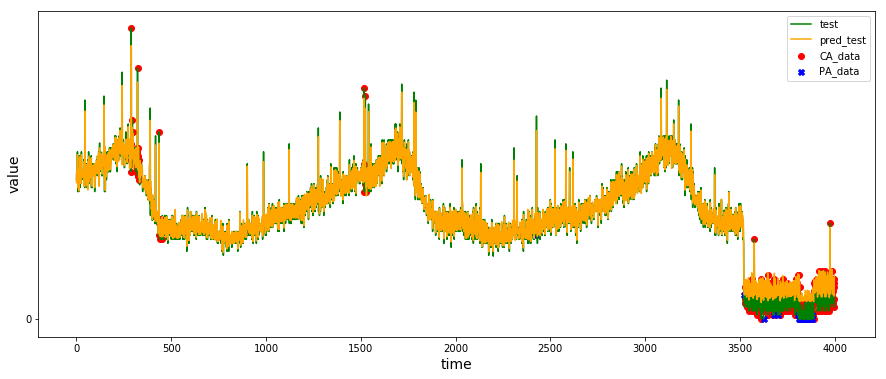

In [103]:
from matplotlib.pyplot import MultipleLocator
test1=test.reshape(test.shape[0]*test.shape[1],1)
test_pred1=test_pred.reshape(test_pred.shape[0]*test_pred.shape[1],1)
plt.figure(figsize=(15,6))
plt.xlabel('time',fontsize=14)
plt.ylabel('value',fontsize=14)
y_major_locator=MultipleLocator(100)
ax=plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
#plt.ylim(0,1000)
plt.plot(test1[0:],color="green",label='test')
plt.plot(test_pred1[0:],color="orange",linestyle='-',label='pred_test')
plt.scatter(Cerro_x,Cerro_y,color="red",label='CA_data')
plt.scatter(Perro_x,Perro_y,color="blue",marker="X",label='PA_data')          
plt.legend()


In [104]:
Pred_label=[]
for i in range(len(pred_label)):
    if pred_label[i]==0:
        Pred_label.append(0)
    else:
        Pred_label.append(1)

In [105]:
print("CA:",pred_label.count(1))
print("PA:",pred_label.count(2))
ROC=roc_auc_score(test_label,Pred_label)
print("ROC_AUC score:{:2%}".format(ROC))  
precision, recall, _thresholds = precision_recall_curve(test_label, Pred_label)
PR_AUC = auc(recall, precision)
print("PR-AUC score:{:2%}".format(PR_AUC)) 

CA: 498
PA: 39
ROC_AUC score:98.716856%
PR-AUC score:93.953631%


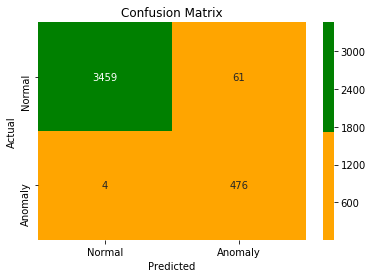

In [106]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(6, 4))
        colors=[ "orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

viz = Visualization()
viz.draw_confusion_matrix(test_label,Pred_label)